We are exploring if a Fourier loss function that normalizes across the scales is a good way to ensure our super-resolution CNN is scale-aware. We do this specifically for the case where we want to predict the anomaly between the HR and LR data.

# Data preprocessing

In [32]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

import scipy
from scipy.fft import fft2, ifft2, fftshift, ifftshift

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from model_eval_plotting import evaluate_model
from model_eval_plotting import plot_predictions_vs_targets

from CNN_setup import SimpleCNN
from CNN_setup import TensorDataset

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.fft


In [33]:
ds_HR1 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr1.zarr", engine="zarr", chunks={}
) 
ds_HR2 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr2.zarr", engine="zarr", chunks={}
) 
ds_HR3 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr3.zarr", engine="zarr", chunks={}
) 
ds_HR4 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr4.zarr", engine="zarr", chunks={}
) 
ds_HR5 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr5.zarr", engine="zarr", chunks={}
) 
datasets = [ds_HR1, ds_HR2, ds_HR3, ds_HR4, ds_HR5]

# Concatenate along the 'time' dimension
combined_HR = xr.concat(datasets, dim='time')
combined_HR

<xarray.Dataset> Size: 109MB
Dimensions:   (time: 185, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 1kB 0181-01-01 12:00:00 ... 0185-12-26 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    q_ref     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    slp       (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>

In [34]:
# Note that all this data is LR because it is filtered

ds_train1 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr1.zarr", engine="zarr", chunks={}
) 
ds_train2 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr2.zarr", engine="zarr", chunks={}
) 
ds_train3 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr3.zarr", engine="zarr", chunks={}
) 
ds_train4 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr4.zarr", engine="zarr", chunks={}
) 
ds_train5 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr5.zarr", engine="zarr", chunks={}
) 
datasets = [ds_train1, ds_train2, ds_train3, ds_train4, ds_train5]

# Concatenate along the 'time' dimension
combined_LR = xr.concat(datasets, dim='time')
combined_LR

<xarray.Dataset> Size: 217MB
Dimensions:   (time: 185, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 1kB 0181-01-01 12:00:00 ... 0185-12-26 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    q_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    slp       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>

In [35]:
combined_SGS = combined_HR - combined_LR
combined_SGS

<xarray.Dataset> Size: 217MB
Dimensions:   (time: 185, xt_ocean: 150, yt_ocean: 163)
Coordinates:
  * time      (time) object 1kB 0181-01-01 12:00:00 ... 0185-12-26 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    q_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    slp       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>

In [37]:
# Total number of samples
n_samples = len(combined_HR.time)  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
# HR
train_data_SGS = combined_SGS.isel(time=train_indices)
val_data_SGS = combined_SGS.isel(time=val_indices)
test_data_SGS = combined_SGS.isel(time=test_indices)
# LR
train_data_LR = combined_LR.isel(time=train_indices)
val_data_LR = combined_LR.isel(time=val_indices)
test_data_LR = combined_LR.isel(time=test_indices)

print("Training set size:", len(train_data_SGS.time))
print("Validation set size:", len(val_data_SGS.time))
print("Testing set size:", len(test_data_SGS.time))

Training set size: 129
Validation set size: 27
Testing set size: 29


In [38]:
# Extract HR data
## training
urel_SGS_train = train_data_SGS.u_rel.values
vrel_SGS_train = train_data_SGS.v_rel.values
sst_SGS_train = train_data_SGS.sst.values
tref_SGS_train = train_data_SGS.t_ref.values
qref_SGS_train = train_data_SGS.q_ref.values
slp_SGS_train = train_data_SGS.slp.values

## testing
urel_SGS_val = val_data_SGS.u_rel.values
vrel_SGS_val = val_data_SGS.v_rel.values
sst_SGS_val = val_data_SGS.sst.values
tref_SGS_val = val_data_SGS.t_ref.values
qref_SGS_val = val_data_SGS.q_ref.values
slp_SGS_val = val_data_SGS.slp.values

## validation
urel_SGS_test = test_data_SGS.u_rel.values
vrel_SGS_test = test_data_SGS.v_rel.values
sst_SGS_test = test_data_SGS.sst.values
tref_SGS_test = test_data_SGS.t_ref.values
qref_SGS_test = test_data_SGS.q_ref.values
slp_SGS_test = test_data_SGS.slp.values

In [39]:
# Extract LR data
## training
urel_LR_train = train_data_LR.u_rel.values
vrel_LR_train = train_data_LR.v_rel.values
sst_LR_train = train_data_LR.sst.values
tref_LR_train = train_data_LR.t_ref.values
qref_LR_train = train_data_LR.q_ref.values
slp_LR_train = train_data_LR.slp.values

## validation
urel_LR_val = val_data_LR.u_rel.values
vrel_LR_val = val_data_LR.v_rel.values
sst_LR_val = val_data_LR.sst.values
tref_LR_val = val_data_LR.t_ref.values
qref_LR_val = val_data_LR.q_ref.values
slp_LR_val = val_data_LR.slp.values

## testing
urel_LR_test = test_data_LR.u_rel.values
vrel_LR_test = test_data_LR.v_rel.values
sst_LR_test = test_data_LR.sst.values
tref_LR_test = test_data_LR.t_ref.values
qref_LR_test = test_data_LR.q_ref.values
slp_LR_test = test_data_LR.slp.values


In [40]:
# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)

#training
training_NN_inputs_urel = torch.tensor(np.stack([urel_LR_train, urel_SGS_train], axis=3))
training_NN_inputs_vrel = torch.tensor(np.stack([vrel_LR_train, vrel_SGS_train], axis=3))
training_NN_inputs_sst = torch.tensor(np.stack([sst_LR_train, sst_SGS_train], axis=3))
training_NN_inputs_tref = torch.tensor(np.stack([tref_LR_train, tref_SGS_train], axis=3))
training_NN_inputs_qref = torch.tensor(np.stack([qref_LR_train, qref_SGS_train], axis=3))
training_NN_inputs_slp = torch.tensor(np.stack([slp_LR_train, slp_SGS_train], axis=3))

#validation
val_NN_inputs_urel = torch.tensor(np.stack([urel_LR_val, urel_SGS_val], axis=3))
val_NN_inputs_vrel = torch.tensor(np.stack([vrel_LR_val, vrel_SGS_val], axis=3))
val_NN_inputs_sst = torch.tensor(np.stack([sst_LR_val, sst_SGS_val], axis=3))
val_NN_inputs_tref = torch.tensor(np.stack([tref_LR_val, tref_SGS_val], axis=3))
val_NN_inputs_qref = torch.tensor(np.stack([qref_LR_val, qref_SGS_val], axis=3))
val_NN_inputs_slp = torch.tensor(np.stack([slp_LR_val, slp_SGS_val], axis=3))

#testing
testing_NN_inputs_urel = torch.tensor(np.stack([urel_LR_test, urel_SGS_test], axis=3))
testing_NN_inputs_vrel = torch.tensor(np.stack([vrel_LR_test, vrel_SGS_test], axis=3))
testing_NN_inputs_sst = torch.tensor(np.stack([sst_LR_test, sst_SGS_test], axis=3))
testing_NN_inputs_tref = torch.tensor(np.stack([tref_LR_test, tref_SGS_test], axis=3))
testing_NN_inputs_qref = torch.tensor(np.stack([qref_LR_test, qref_SGS_test], axis=3))
testing_NN_inputs_slp = torch.tensor(np.stack([slp_LR_test, slp_SGS_test], axis=3))

## Rescaling Fourier transformed data

### HR and LR Images in Real Space

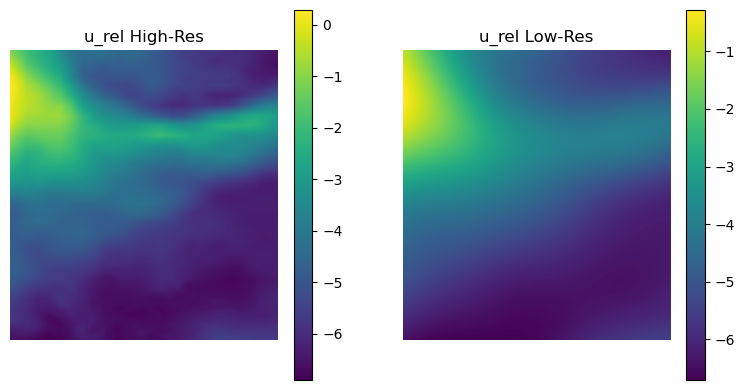

In [8]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].imshow(combined_HR.u_rel.isel(time=0))
axes[0].set_title("u_rel High-Res")
axes[0].axis('off')  # Turn off the axes
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
im2 = axes[1].imshow(combined_LR.u_rel.isel(time=0))
axes[1].set_title("u_rel Low-Res")
axes[1].axis('off')  # Turn off the axes
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()


### Real Space vs Fourier Space

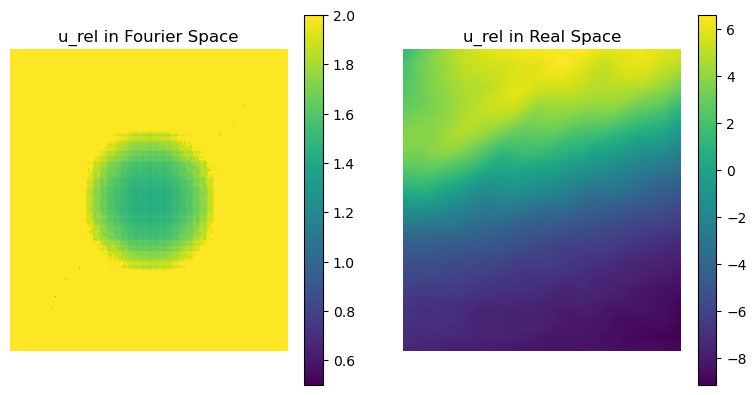

In [9]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].imshow(np.abs(fft2(urel_HR_train[0])), vmin=0.5, vmax=2)
axes[0].set_title("u_rel in Fourier Space")
axes[0].axis('off')  # Turn off the axes
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
im2 = axes[1].imshow(urel_HR_train[0])
axes[1].set_title("u_rel in Real Space")
axes[1].axis('off')  # Turn off the axes
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()

### Normalizing in Fourier Space

We use the formula $\hat{F}(k) = \frac{F(k)}{max |F(k)|}$. Note that to plot, I multiply $\hat{F}(k)$ by 1000 to plot.

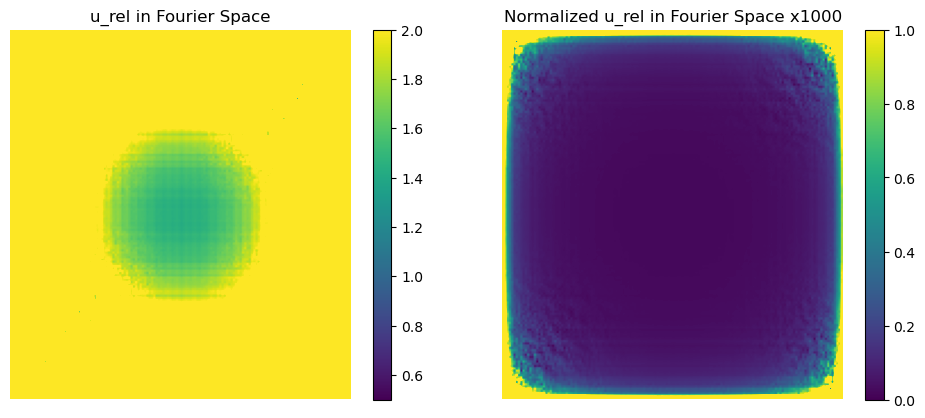

In [12]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].imshow(np.abs(fft2(urel_HR_train[0])), vmin=0.5, vmax=2)
axes[0].set_title("u_rel in Fourier Space")
axes[0].axis('off')  # Turn off the axes
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
urel_fft = np.abs(fft2(urel_HR_train[0]))
urel_fft_max = urel_fft.max()
im2 = axes[1].imshow(np.abs(urel_fft/urel_fft_max)*1000, vmin=0, vmax=1)
axes[1].set_title("Normalized u_rel in Fourier Space x1000")
axes[1].axis('off')  # Turn off the axes
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()

## Custom Loss Function

We create a custom loss function as such

$loss = \frac{\beta}{N}\sum_{k=0}^N |f_{target}(x) - f_{output}(x)| ^2 + \alpha \frac{1}{N}\sum_{k=0}^N |F_{target}(k) - F_{output}(k)| ^2$, \
where \
$\hat{F}(k) = \frac{F(k)}{max |F(k)|}$ and $F(k) = \int_{-\infty}^\infty f(x) e^{-2\pi ikx} dx$

In [8]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        super(CustomLoss, self).__init__()
        self.alpha = alpha 
        self.beta = beta

    def forward(self, outputs, targets):
        output_fft = torch.fft.fft2(outputs)
        output_fft_max = output_fft.abs().max()
        target_fft = torch.fft.fft2(targets)
        target_fft_max = target_fft.abs().max()
        output_fft_normalized = output_fft / output_fft_max
        target_fft_normalized = target_fft / target_fft_max
        loss_fft = torch.mean(torch.abs(output_fft_normalized - target_fft_normalized) ** 2)
        loss_real = torch.mean((outputs - targets) ** 2)
        loss_total = self.beta * loss_real + self.alpha * loss_fft
        return loss_total

## Training the CNN for $u_{rel}$

In [46]:
# Set the values you want
in_channels = 1  # num of input channels
image_height = training_NN_inputs_urel.shape[1]
image_width = training_NN_inputs_urel.shape[2]
output_channels = 1 #output can be in grayscale, num of output channels

# Instantiate the model with the parameters
model = SimpleCNN(in_channels, image_height, image_width, output_channels)

# Check the model architecture
print(model)

# Loss criterion and optimizer
criterion = CustomLoss(beta=1.0, alpha=0.0)  # Use appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=0.001) #, weight_decay=0.01)

# Define the number of input channels 
input_channels = 1
train_dataset = TensorDataset(training_NN_inputs_urel, input_channels)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

val_dataset = TensorDataset(val_NN_inputs_urel, input_channels)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

num_epochs = 100  # Number of epochs to train
loss_values = []  # Training loss for each epoch
val_loss_values = []  # Validation loss for each epoch

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in train_loader:
        # Batch size 1 handling (inputs shape: [1, y, x, variables ])
        inputs = inputs.squeeze(0).permute(2, 0, 1).float()  # Reshape to (vars, y, x) --> CNN input expects vars/channels first
        targets = targets.squeeze(0).float()  # Shape: (y, x)
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension back for CNN (shape: [1, vars, y, x])
        targets = targets.unsqueeze(0)  # Add batch dimension to targets

        # Compute loss
        loss = criterion(outputs, targets)

        # Zero/reset the parameter gradients before next iteration
        optimizer.zero_grad()

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = running_loss / len(train_loader)
    loss_values.append(average_loss)

    # Validation phase: Use evaluate_model
    val_loss, _, _ = evaluate_model(model, val_loader, criterion)
    val_loss_values.append(val_loss)

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Training Loss: {average_loss:.4f}, Validation Loss: {val_loss:.4f}")

print("Training complete!")

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=23040, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=24450, bias=True)
)
Epoch [1/100], Training Loss: 0.1604, Validation Loss: 0.1580
Epoch [2/100], Training Loss: 0.1545, Validation Loss: 0.1559
Epoch [3/100], Training Loss: 0.1543, Validation Loss: 0.1565
Epoch [4/100], Training Loss: 0.1538, Validation Loss: 0.1558
Epoch [5/100], Training Loss: 0.1534, Validation Loss: 0.1555
Epoch [6/100], Training Loss: 0.1533, Validation Loss: 0.1554
Epoch [7/100], Training Loss: 0.1532, Validation Loss: 0.1553
Epoch [8/100], Training Loss: 0.1531, Validation Loss: 0.1553
Epoch [9/100], Training Loss: 0.1531, Validation Loss: 0.1553
Epoch [10/100], Training Loss: 0.1531, Validation Loss: 0.1553
Epoch [1

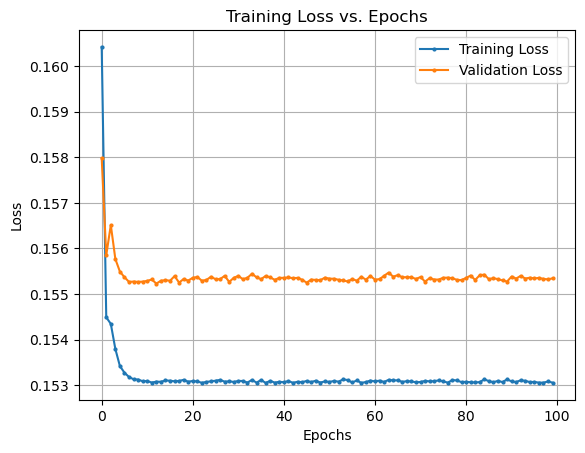

In [47]:
epochs_plot = list(range(0,num_epochs))

# Plot training losses against epochs
plt.plot(epochs_plot, loss_values, marker='o', markersize=2, label='Training Loss')
plt.plot(epochs_plot, val_loss_values, marker='o', markersize=2, label='Validation Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Testing $u_{rel}$

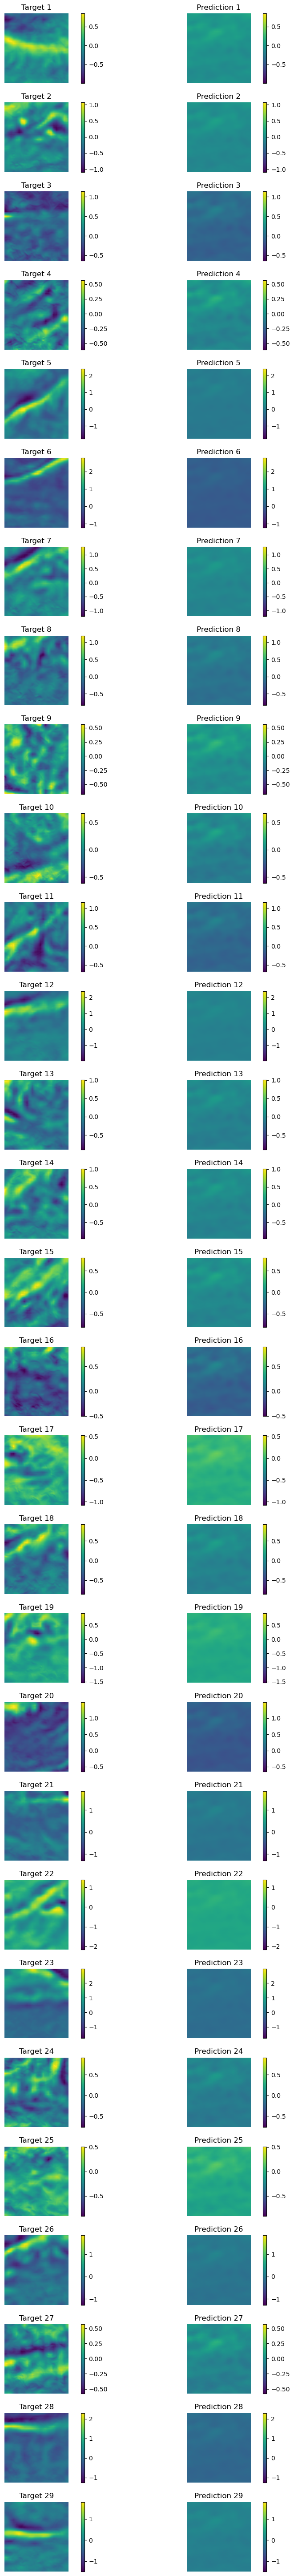

In [48]:
# Assuming you have a test dataset similar to your training dataset
test_dataset = TensorDataset(testing_NN_inputs_urel, input_channels)  # Replace with your actual test tensor data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set shuffle=False for testing

# Define your criterion (loss function)
criterion = CustomLoss(beta=1.0, alpha=0.0)  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=len(test_data_SGS.time))  # Change num_samples as needed

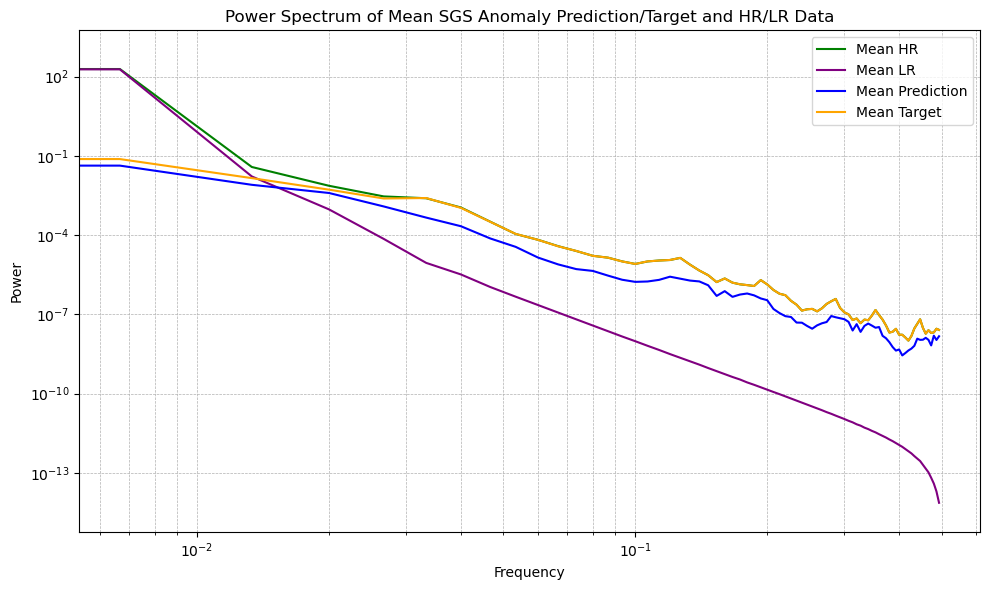

In [49]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(predictions.shape[-2]),  # Replace with actual coordinates if available
    'xt_ocean': range(predictions.shape[-1])   # Replace with actual coordinates if available
}

# Compute the mean prediction and target across samples
test_data_LR = combined_LR.isel(time=test_indices)
urel_LR_test = test_data_LR.u_rel
mean_LR = urel_LR_test.mean(dim='time').values
test_data_HR = combined_HR.isel(time=test_indices)
urel_HR_test = test_data_HR.u_rel
mean_HR = urel_HR_test.mean(dim='time').values
mean_prediction = predictions.squeeze(1).mean(dim=0)  # Squeeze to remove the channel dimension and compute mean
mean_target = targets.mean(dim=0)

# Convert to xarray.DataArray
mean_LR_da = xr.DataArray(mean_LR, dims=dims, coords=coords)
mean_HR_da = xr.DataArray(mean_HR, dims=dims, coords=coords)
mean_prediction_da = xr.DataArray(mean_prediction.numpy(), dims=dims, coords=coords)
mean_target_da = xr.DataArray(mean_target.numpy(), dims=dims, coords=coords)

# Compute power spectrum for mean prediction and target
ps_LR = xrft.power_spectrum(mean_LR_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_HR = xrft.power_spectrum(mean_HR_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_pred = xrft.power_spectrum(mean_prediction_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_targ = xrft.power_spectrum(mean_target_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_HR.freq_xt_ocean, ps_HR, label='Mean HR', color='green')
plt.plot(ps_LR.freq_xt_ocean, ps_LR, label='Mean LR', color='purple')
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Mean Prediction', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Mean Target', color='orange')

# Configure the plot
plt.title("Power Spectrum of Mean SGS Anomaly Prediction/Target and HR/LR Data")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()
